In [1]:
import pandas as pd
import numpy as np
import gensim
import opencorpora
from pymystem3 import Mystem
from many_stop_words import get_stop_words
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

____
## Обучение
Обучаем модель word2vec на корпусе русского языка

In [142]:
ru_stopwords = get_stop_words('ru')

In [143]:
reader = opencorpora.CorpusReader('data/opencorpora/annot.opcorpora.xml')
stem = Mystem(entire_input=False)

In [144]:
%%time
sents = [list(filter(lambda token: token not in ru_stopwords, stem.lemmatize(sent))) for sent in reader.iter_raw_sents()]

CPU times: user 1min 44s, sys: 5.22 s, total: 1min 49s
Wall time: 3min 15s


In [5]:
%%time
model = gensim.models.Word2Vec(sentences=sents, min_count=3)

CPU times: user 14.4 s, sys: 24 ms, total: 14.4 s
Wall time: 5.97 s


In [10]:
model.save('data/word2vec/word2vec.model')

## Тестирование

In [2]:
model = gensim.models.Word2Vec.load('data/word2vec/word2vec.model')

In [3]:
df = pd.read_csv('data/judicial_orders_lemmas.csv')
code = pd.read_csv('data/criminal_code.csv')
df['lemmas'] = df['lemmas'].map(eval)
df['labels'] = df['labels'].map(eval)
code['lemmas'] = code['lemmas'].map(eval)

In [4]:
def get_doc_embedding(doc):
    """
    Возвращает массив векторов для каждого известного модели токена в документе.
    """
    res = []
    for token in doc:
        try:
            res.append(model.wv.get_vector(token))
        except KeyError:
            pass
    return res

Считаем среднее по векторам токенов для каждого текста:

In [5]:
df['w2v'] = df['lemmas'].map(lambda doc: get_doc_embedding(doc))
df['mean_w2v'] = df['w2v'].map(lambda x: np.mean(x, axis=0))
code['w2v'] = code['lemmas'].map(lambda doc: get_doc_embedding(doc))
code['mean_w2v'] = code['w2v'].map(lambda x: np.mean(x, axis=0))

Вычисляем косинусные расстояния между вектором судебного постановления и статей УК РФ

In [160]:
def measure_distances(vec, distance):
    return code['mean_w2v'].map(lambda x: distance(vec, x)).tolist()

from scipy.spatial.distance import cosine
df['distances'] = df['mean_w2v'].map(lambda vec: measure_distances(vec, cosine))

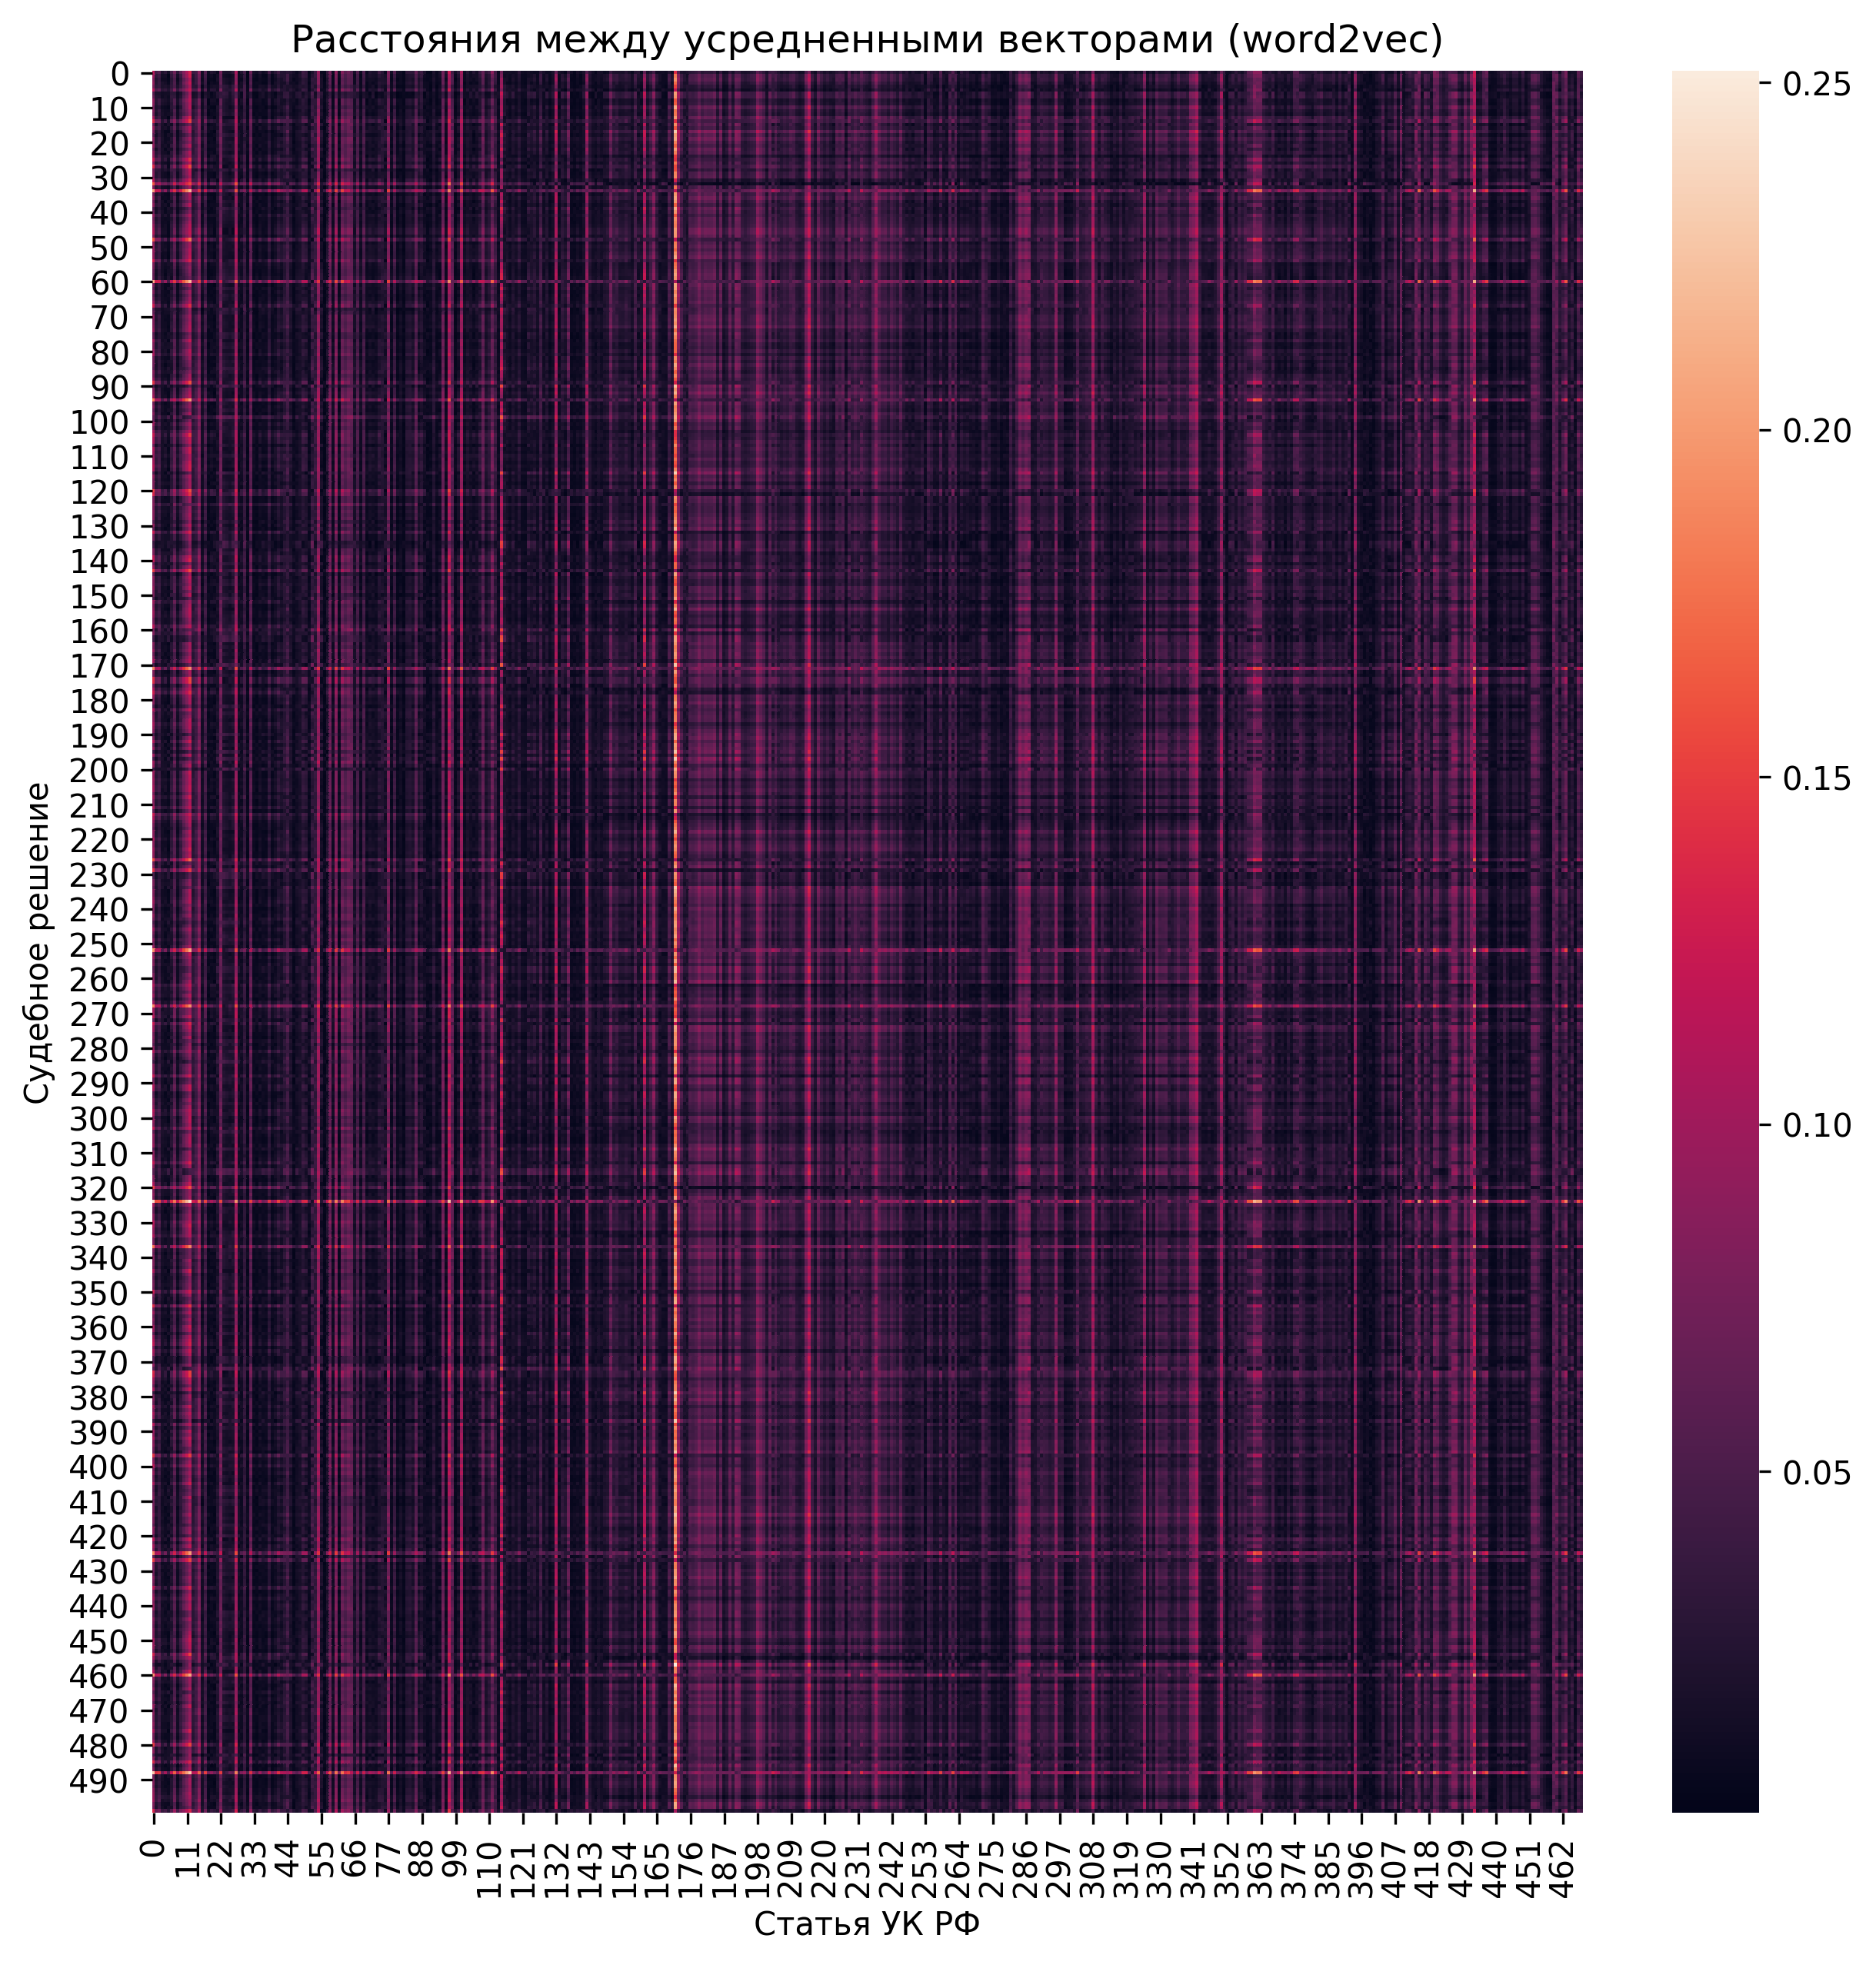

In [161]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=300)
_ = sns.heatmap(df[:500]['distances'].tolist(), ax=ax)
ax.set_title('Расстояния между усредненными векторами (word2vec)')
ax.set_ylabel('Судебное решение')
ax.set_xlabel('Статья УК РФ')
pass

Уже на этом рисунке понятно, что все судебные решения получились очень похожими в контексте расстояния до статей УК

___
Записываем расстояния в виде словаря {`номер_статьи`: `расстояние`, ...}

In [13]:
map_distances = lambda distances: {number: distance for number, distance in zip(code['number'].tolist(), distances)}

In [16]:
df['distances'] = df['distances'].map(map_distances)

Группируем, каждый набор расстояний до статей по округленным расстояниям

In [42]:
from collections import defaultdict

def group_by_dist(distances):
    v = defaultdict(list)
    for number, distance in sorted(distances.items()):
        v[round(distance, 3)].append(number)
    return v

In [43]:
df['grouped_distances'] = df['distances'].map(group_by_dist)

В стиле scikit-learn напишем rf-классификатор

In [53]:
w2v = dict(zip(model.wv.index2word, model.wv.vectors))

In [71]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec, dim=100):
        self.word2vec = word2vec
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

Превращает леммы в усредненный по всему тексту вектор

In [74]:
MeanEmbeddingVectorizer(w2v).transform(df['lemmas']).shape

(9533, 100)

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

rf_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("random forest", RandomForestClassifier(n_estimators=100))])

In [84]:
rf_w2v = rf_w2v.fit(code['lemmas'].tolist(), code['number'].astype(str))

In [79]:
df['pred'] = rf_w2v.predict(df['lemmas'])

Вычисляем долю предсказаний, которые оказались в реальном решении суда:

In [92]:
one_intersect_score = lambda row: 1 if len(set(row['labels']).intersection(set([float(row['pred'])]))) > 0 else 0

In [93]:
df.apply(one_intersect_score, axis=1).sum() / df.shape[0]

0.0032518619532151474

Попробуем ввести веса на каждый токен при вычислении вектора для текста с помощью TF_IDF

In [133]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec, word2weight, dim=100):
        self.word2vec = word2vec
        self.word2weight = word2weight
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Обучаем TF_IDF на всех предложениях Opencorpora

In [145]:
tfidf = TfidfVectorizer(analyzer=lambda x: x).fit(sents) # массив sents объявлен в самом начале ноутбука
word2weight = {w: tfidf.idf_[i] for w, i in tfidf.vocabulary_.items()}

Посчитаем расстояния от этих векторов до статей кодекса

In [156]:
df['tf_idf_w2v'] = pd.Series(list(TfidfEmbeddingVectorizer(w2v, word2weight).transform(df['lemmas'].tolist())))

In [158]:
df['tfidf_distances'] = df['tf_idf_w2v'].map(lambda vec: measure_distances(vec, cosine))

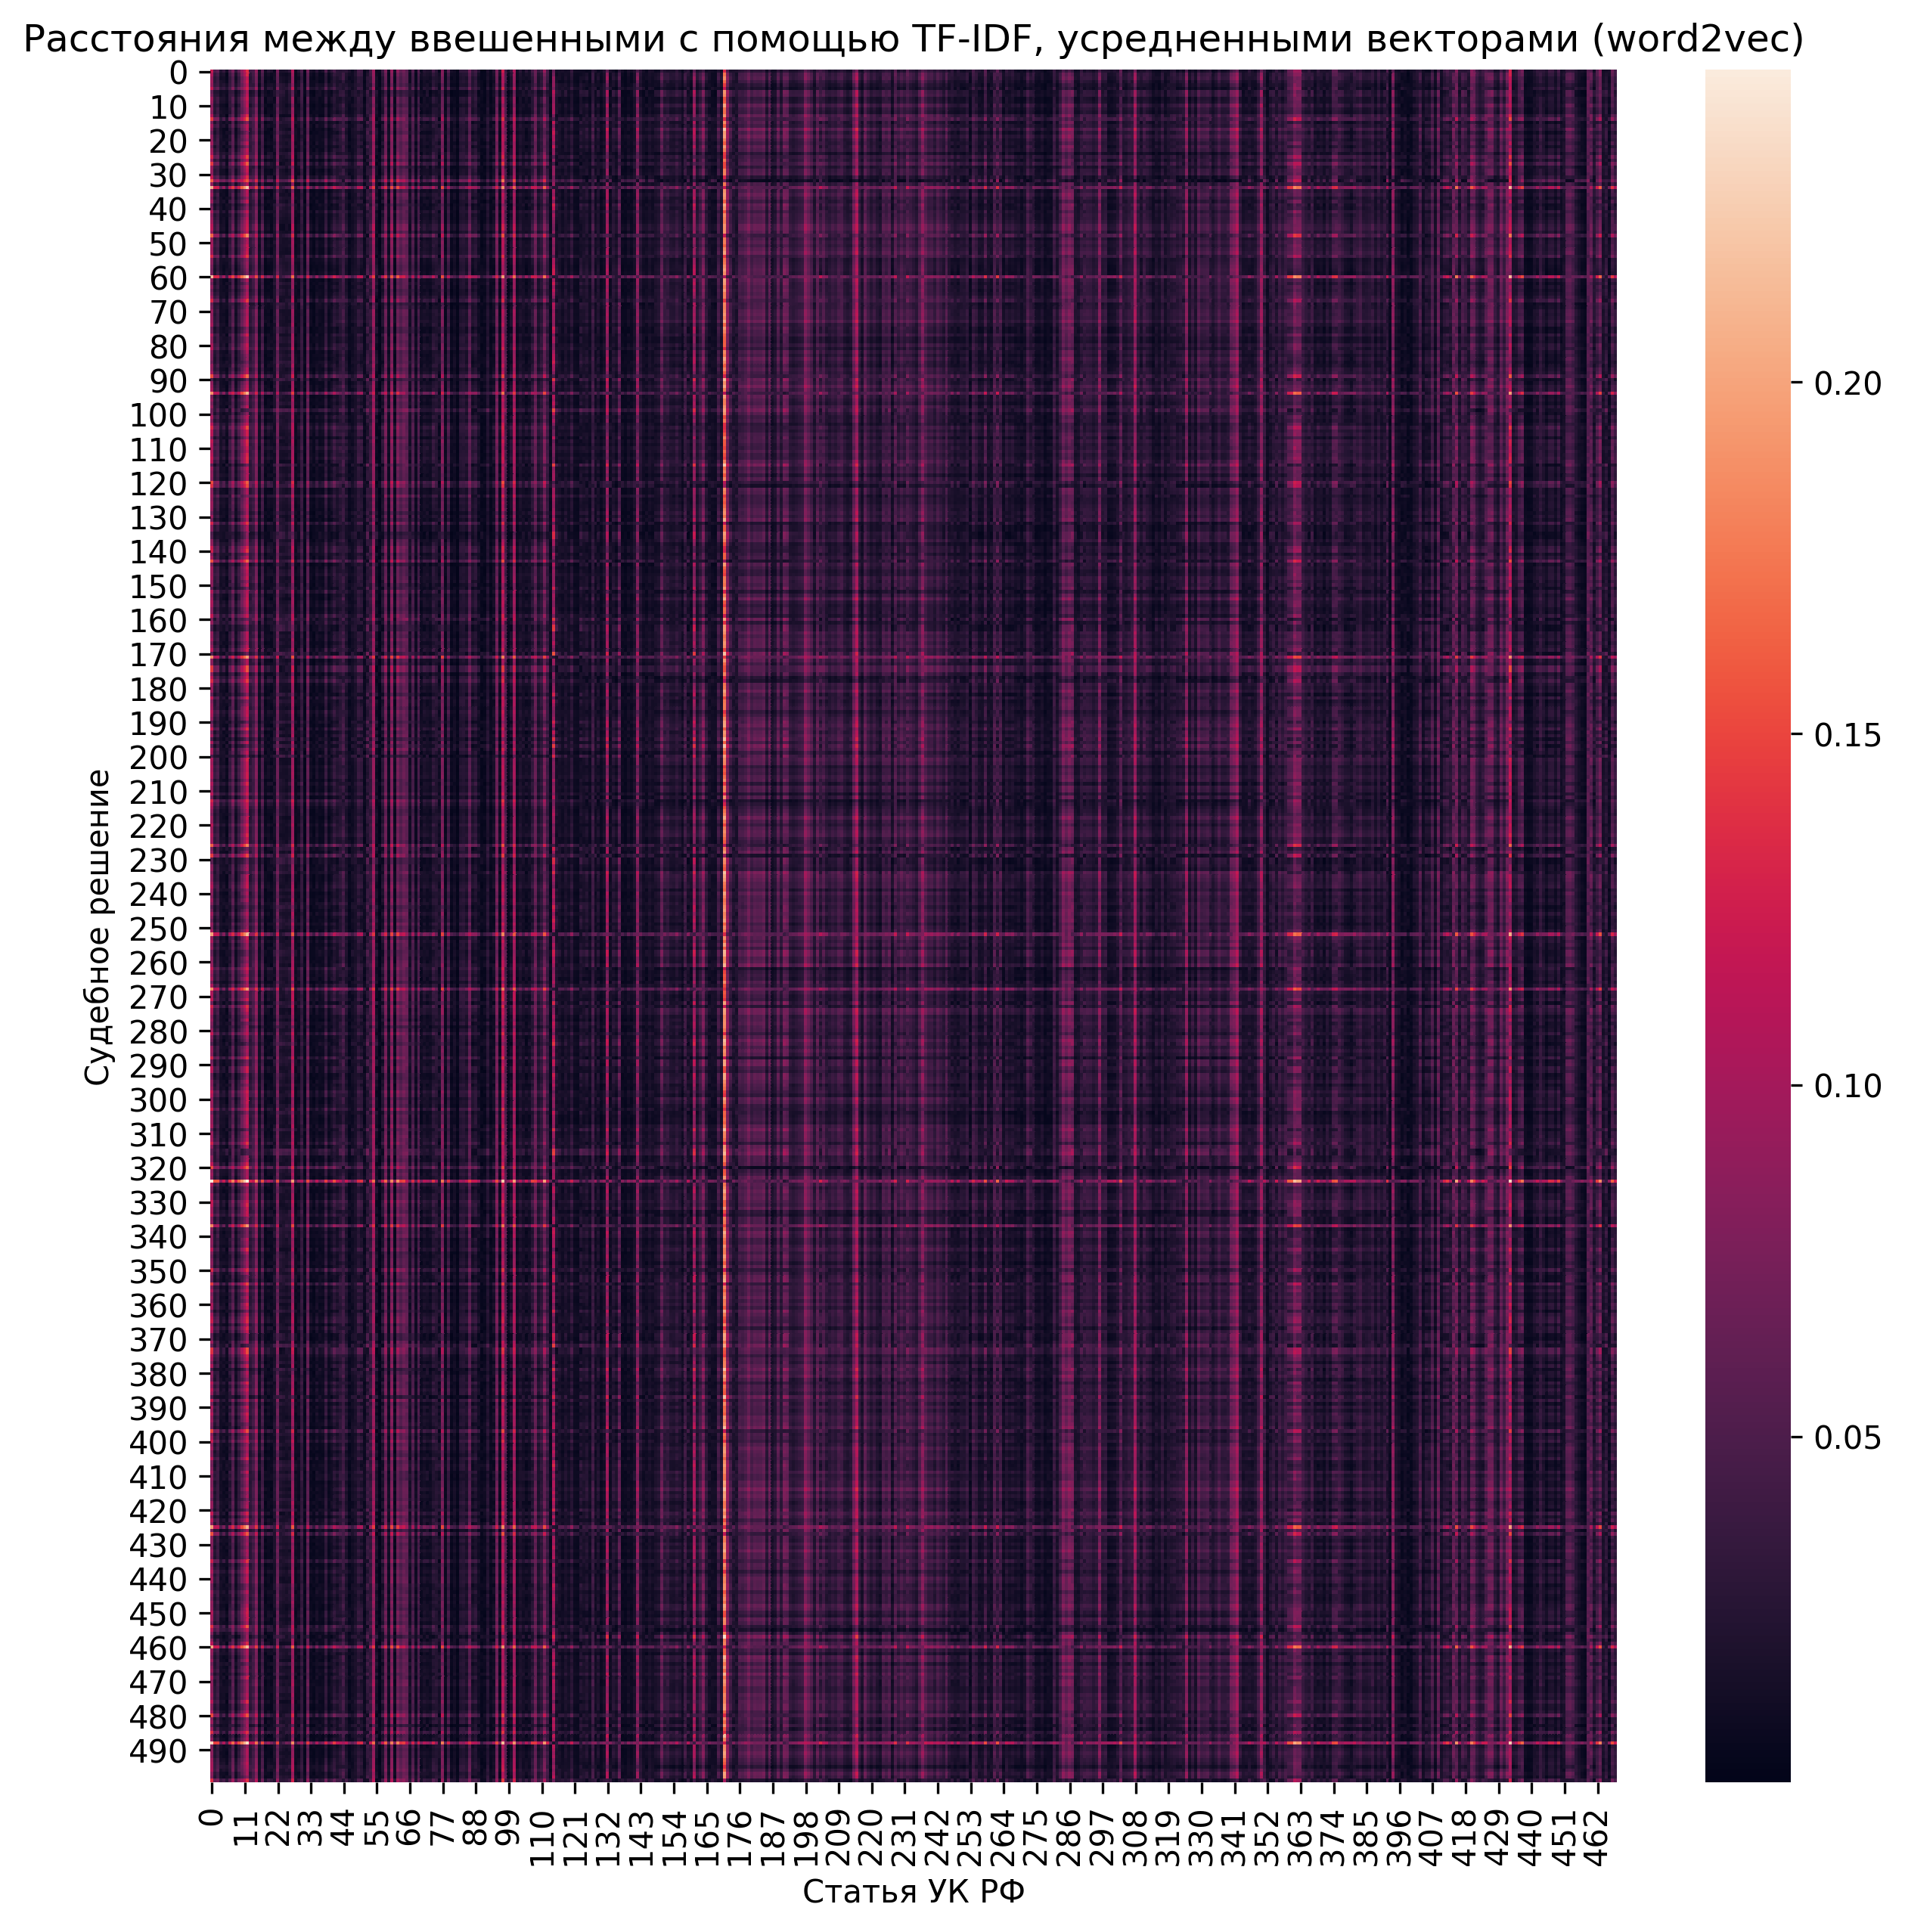

In [162]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=300)
_ = sns.heatmap(df[:500]['tfidf_distances'].tolist(), ax=ax)
ax.set_title('Расстояния между ввешенными с помощью TF-IDF, усредненными векторами (word2vec)')
ax.set_ylabel('Судебное решение')
ax.set_xlabel('Статья УК РФ')
pass

Попробуем обучить классификатор

In [146]:
tfidf_w2v = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v, word2weight)),
    ("random forest", RandomForestClassifier(n_estimators=100))])

In [147]:
tfidf_w2v = tfidf_w2v.fit(code['lemmas'].tolist(), code['number'].astype(str))

In [148]:
df['pred'] = tfidf_w2v.predict(df['lemmas'])

In [149]:
df.apply(one_intersect_score, axis=1).sum() / df.shape[0]

0.002832266862477709